## World Wide Products

#### Submitted By: Arman Ghasemi KU ID: 2970754 Email:arman.ghasemi@ku.edu

### Importing libraries

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import dateutil
from fbprophet import Prophet

### Reading Dataset

In [2]:

Path = "/Users/a454g185/Downloads/productdemandforecasting/"
df = pd.read_csv(Path + "Historical Product Demand.csv")
print(df.shape)
df.head(10)

(1048575, 5)


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
5,Product_0979,Whse_J,Category_028,2012/4/19,500
6,Product_0979,Whse_J,Category_028,2012/6/5,500
7,Product_0979,Whse_J,Category_028,2012/6/27,500
8,Product_0979,Whse_J,Category_028,2012/7/23,500
9,Product_0979,Whse_J,Category_028,2012/8/29,500


### Understanding and Cleaning Dataset

To understand the data better the describe function is very useful.

In [3]:
df.describe()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575
unique,2160,4,33,1729,3828
top,Product_1359,Whse_J,Category_019,2013/9/27,1000
freq,16936,764447,481099,2075,112682


The number of unique Product_Code is 2160, Warehouse is 4 and  Product_Categorty is 33.

In [4]:
df['Order_Demand'] = (df['Order_Demand'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))
df.dtypes

Product_Code         object
Warehouse            object
Product_Category     object
Date                 object
Order_Demand        float64
dtype: object

The null values should be dropped.

In [5]:
df.isnull().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [6]:
df = df.dropna()
print(df.shape)
df.isnull().sum()

(1037336, 5)


Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [7]:
df['Date'].min(), df['Date'].max()

('2011/1/8', '2017/1/9')

We have data from January 2011 to January 2017

## Feature Engineering

In [23]:
years = []
for row in df['Date']:
    year = row.split('/')[0]
    years.append(year)
df.insert(len(df.columns), 'Year', years, True)
df.head()

AttributeError: 'Timestamp' object has no attribute 'split'

In [9]:
pro = df.groupby("Year")['Order_Demand'].sum().reset_index()
pro.head(10)

,Year,Order_Demand
0,2011,7.509986e+06
1,2012,9.417429e+08
2,2013,1.009219e+09
3,2014,1.064272e+09
4,2015,1.095445e+09
5,2016,9.853681e+08
6,2017,2.949670e+05


In [10]:
df['Year'] = (df['Year'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(int))
df.dtypes

Product_Code         object
Warehouse            object
Product_Category     object
Date                 object
Order_Demand        float64
Year                  int32
dtype: object

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


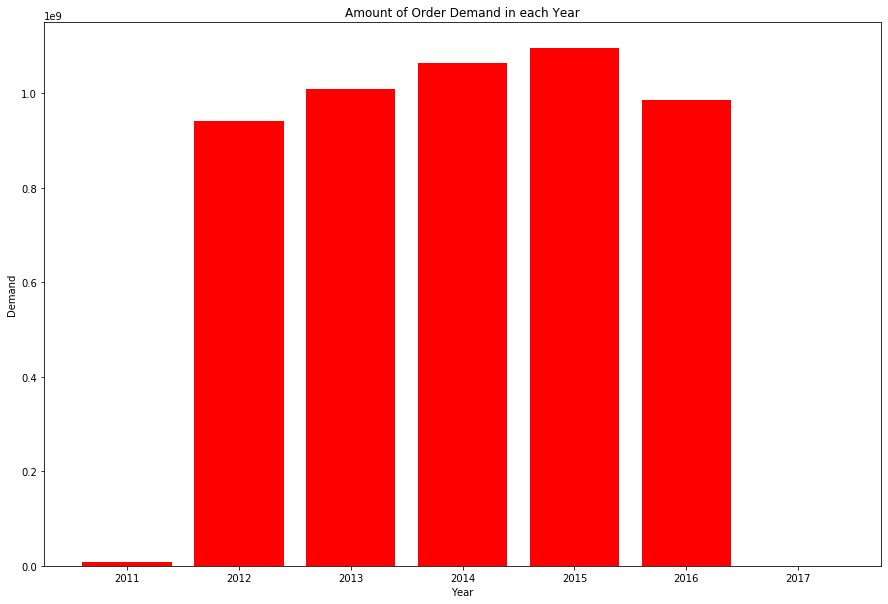

In [11]:
plt.figure(figsize = (15,10))
plt.bar(pro['Year'], pro['Order_Demand'], color='red')
plt.xlabel("Year")
plt.ylabel("Demand")
plt.title("Amount of Order Demand in each Year")
plt.show()

It can be seen that the order demand raise from 2012 to 2015 but it slightly drop in 2016. And also there is no enough data from 2017 so it is not good idea to rely to the value which is shown in the graph.

## Time Series Forecasting

In [12]:
Encoder = LabelEncoder()
df['Product_Code'] = Encoder.fit_transform(df['Product_Code'].astype('str'))
df['Warehouse'] = Encoder.fit_transform(df['Warehouse'].astype('str'))
df['Product_Category'] = Encoder.fit_transform(df['Product_Category'].astype('str'))
df['Date'] = df['Date'].apply(dateutil.parser.parse)
df.dtypes

Product_Code                 int32
Warehouse                    int32
Product_Category             int32
Date                datetime64[ns]
Order_Demand               float64
Year                         int32
dtype: object

In [13]:
df_Products1 = df.drop(['Warehouse','Product_Category','Date','Year'],axis = 1)
df_Products1.head()

,Product_Code,Order_Demand
0,982,100.0
1,968,500.0
2,968,500.0
3,968,500.0
4,968,500.0


In [14]:
df_Products2 = df_Products1.groupby(['Product_Code']).agg('sum')
df_Products2.sort_values('Order_Demand', ascending = False).head(5)

,Order_Demand
Product_Code,
1348,470710000.0
1237,288927000.0
82,210427000.0
1330,169777000.0
1284,121992000.0


This means that product code 1348 has maximum order demand. Let's focus on this product.

In [25]:
df_group2 = df[df['Product_Code'] == 1348 ]
df_group2 = df_group2.drop(['Warehouse','Product_Category','Year','Product_Code'],axis = 1)
df_group2.head()

,Date,Order_Demand
276,2012-04-18,80000.0
282,2012-05-21,70000.0
289,2012-06-26,80000.0
292,2012-07-17,100000.0
296,2012-08-24,100000.0


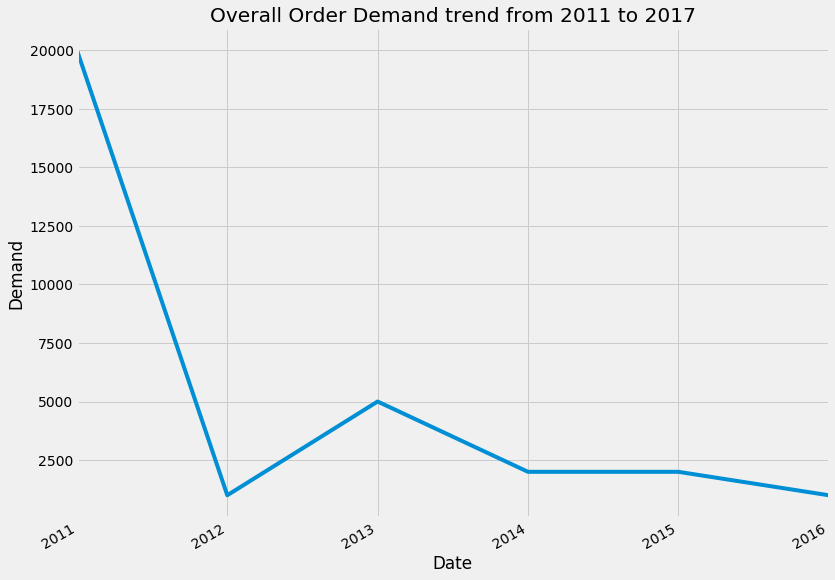

In [27]:
#Overall Demand curve from 2011 to 2017
plt.style.use('fivethirtyeight') 
df['Order_Demand'][2011:2017].plot(subplots=True, figsize=(12,10))
plt.title('Overall Order Demand trend from 2011 to 2017')
plt.xlabel("Date")
plt.ylabel("Demand")
plt.show()

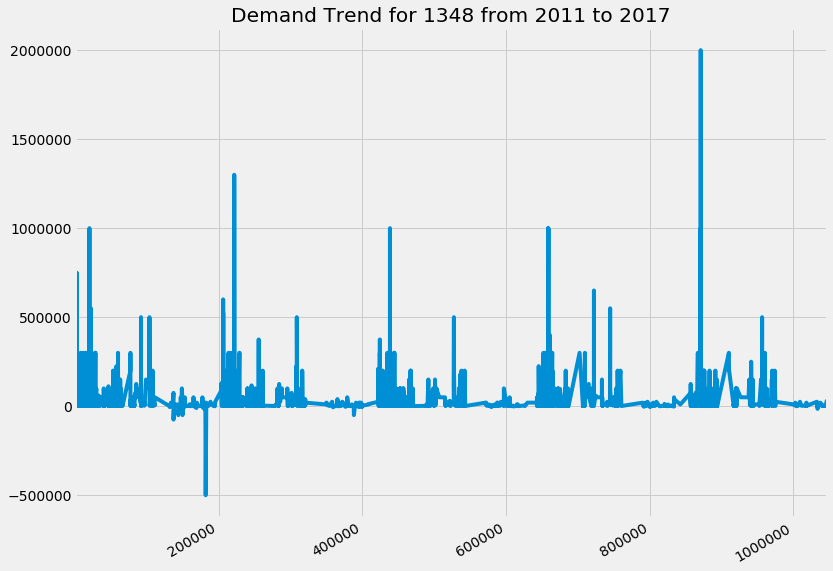

In [29]:
df_group2['Order_Demand'].plot(subplots=True, figsize=(12,10))
plt.title('Demand Trend for 1348 from 2011 to 2017')
plt.show()

In [18]:
df_group2 = df_group2.rename(columns = {'Date': 'ds', 'Order_Demand': 'y' })
df_group2.head()

,ds,y
13167,2012-01-11,2000.0
13175,2012-02-07,300.0
13176,2012-02-07,1200.0
13231,2012-02-28,1500.0
13242,2012-03-07,500.0


In [19]:
obj = Prophet()
obj.fit(df_group2)
future = obj.make_future_dataframe(periods=365)
future.tail()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
2886,2017-12-24
2887,2017-12-25
2888,2017-12-26
2889,2017-12-27
2890,2017-12-28


In [20]:
forecast = obj.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2886,2017-12-24,2047.547790,-2308.180762,6654.725962
2887,2017-12-25,2054.591033,-2482.671019,6783.997751
2888,2017-12-26,1800.668246,-3116.694249,6146.606593
2889,2017-12-27,2034.627621,-2478.893681,6674.665796
2890,2017-12-28,1673.800844,-3260.444732,6040.163729


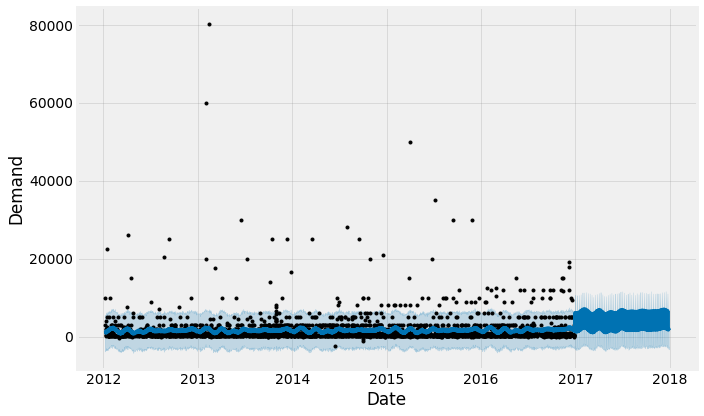

In [34]:
fig1 = obj.plot(forecast , xlabel = 'Date' , ylabel = 'Demand')


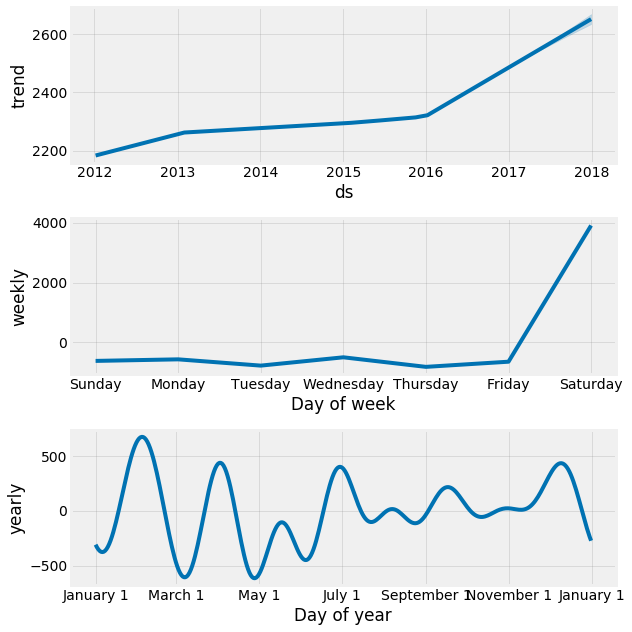

In [22]:
fig2 = obj.plot_components(forecast)

## Conclusion

Looking at the various forecasting plots derived from fbProphet model, for Product_1359 (encoded as 1348), following observations can be made: Demand for this product is increasing from 2012 to 2018 with a small dip from 2014 to 2015
As for the yearly trend, there is a sharp increase and a decrease in demand from January to March
For the weekly trend, demand is high on a sunday and then goes to negative on a saturday.